In [1]:
import numpy as np 
#from mpi4py import MPI 
import time
import matplotlib.pyplot as plt
import h5py
import cmath

#from dedalus import public as de 
#from dedalus.extras import flow_tools
#from dedalus.extras import plot_tools
#import subprocess
#from dedalus.tools import post
import matplotlib.colors as colors
import sys
import csv

/gpfs/runtime/opt/anaconda/3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [54]:
nu = 0.00020704166
dpdz = -0.0098763844 
r_in = 0.5
r_out = 1
ret = 120
if ret == 75: 
    v_m =  1.204527773474421
    path = "/users/czhang54/data/czhang54/Saved_results/ret75/ret75_19_g/ret75_19_g_s1.h5"
elif ret == 120:
    v_m = 1.8515959927340406
    path = "/users/czhang54/data/czhang54/Saved_results/ret120/ret120_15_g/ret120_15_g_s2.h5"
elif ret == 65:
    path_512 = "/users/czhang54/data/czhang54/Saved_results/ret65_512_nl/ret65_7_nl_g/ret65_7_nl_g_s1.h5"
    path = "/users/czhang54/data/czhang54/Saved_results/ret65_512_nl/ret65_7_2_nl_g/ret65_7_2_nl_g_s1.h5"
    v_m = 0.7469258841870151
elif ret == 85:
    path = "/users/czhang54/data/czhang54/Saved_results/ret85_512_nl/ret85_14_nl_g/ret85_14_nl_g_s1.h5"
    v_m = 1.0027760688296272

In [55]:
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 25

In [25]:
#path = "/users/czhang54/data/czhang54/Saved_results/ret65_512_nl/ret65_7_2_nl_g/ret65_7_2_nl_g_s1.h5"
#path_512 = "/users/czhang54/data/czhang54/Saved_results/ret65_512_nl/ret65_7_nl_g/ret65_7_nl_g_s1.h5"

In [56]:
file = h5py.File(path, mode='r')
file_512 = h5py.File(path, mode = 'r')
t = file['scales']['sim_time']
r = file['scales']['r']['1.0'][:]
r = np.asarray(r)
kth = np.arange(0,64)
#kz = np.arange(0,512)
kz_512 = np.arange(0,256)
print(kth)
#th = file['scales']['th']['1.0'][:]
#z = file['scales']['z']['1.0']
#r = file['scales']['r']['1.0']
index = 0

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [57]:
ul = file['tasks']['ul'][index,:,:,:]
uh = file['tasks']['uh'][index,:,:,:]
vl = file['tasks']['vl'][index,:,:,:]
vh = file['tasks']['vh'][index,:,:,:]
wl = file['tasks']['wl'][index,:,:,:]
wh = file['tasks']['wh'][index,:,:,:]

u = ul + uh
v = vl + vh
w = wl + wh

# u = file['tasks']['u'][index,:,:,:]
# v = file['tasks']['v'][index,:,:,:]
# w = file['tasks']['w'][index,:,:,:]

u = u/v_m
v = v/v_m
w = w/v_m


In [58]:
# u_512 = file_512['tasks']['u'][index,:,:,:]
# v_512 = file_512['tasks']['v'][index,:,:,:]
# w_512 = file_512['tasks']['w'][index,:,:,:]

ul_512 = file['tasks']['ul'][index,:,:,:]
uh_512 = file['tasks']['uh'][index,:,:,:]
vl_512 = file['tasks']['vl'][index,:,:,:]
vh_512 = file['tasks']['vh'][index,:,:,:]
wl_512 = file['tasks']['wl'][index,:,:,:]
wh_512 = file['tasks']['wh'][index,:,:,:]

u_512 = ul_512 + uh_512
v_512 = vl_512 + vh_512
w_512 = wl_512 + wh_512

u_512 = u_512/v_m
v_512 = v_512/v_m
w_512 = w_512/v_m

In [59]:
# Fourier Transform on theta
ut = np.fft.fft(u,axis = 1)
vt = np.fft.fft(v,axis = 1)
wt = np.fft.fft(w,axis = 1)
print(ut.shape)

(512, 128, 100)


The zero index represent the 0-frequency term, ut[1:n/2] contains the positive-frequency terms, and ut[n/2+1:] contains the negative-frequency terms, in order of decreasingly negative frequency. ut[n/2] represents both positive and negative Nyquist frequency, and is also purely real for real input. 

I'm going to keep ut[:n/2 -1]

In [60]:
keep = int(ut.shape[1]/2)
print(keep)
ut = ut[:,:keep,:]
vt = vt[:,:keep,:]
wt = wt[:,:keep,:]
print(ut.shape)

64
(512, 64, 100)


In [61]:
uta = np.abs(ut)
vta = np.abs(vt)
wta = np.abs(wt)

#Take square of each to get power
utp = np.square(uta)
vtp = np.square(vta)
wtp = np.square(wta)

In [62]:
p_array = np.zeros(keep)
p_array_1 = np.sum(utp + vtp + wtp, axis = 0)/utp.shape[0] # oh I shouldn't have added them up like this
print(p_array_1.shape)

(64, 100)


Since the array is not evenly distributed over r, an integral is needed

In [63]:
r_out = 1
r_in = 0.5

for TH in range(keep):
    for R in range(len(r)):
        if R == len(r) - 1:
            rdr = r[R]*(1 - r[R])
        else:
            rdr = r[R]*(r[R + 1] - r[R])
        p_array[TH] += p_array_1[TH][R]*rdr
p_array = p_array/(0.5*(r_out**2 - r_in**2))

In [64]:
law = [0 if k == 0 else np.sign(k)*(np.abs(k) ** (-5/3)) for k in kth]

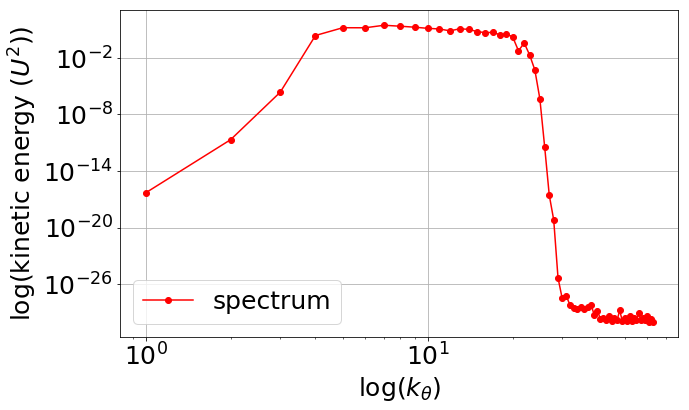

In [65]:
#fig = plt.figure(figsize = (4.8,3.6))
fig = plt.figure(figsize = (10,6))
#y_list = np.power(kth1,-5/3)                
ax = fig.add_subplot(111)
p = plt.plot(kth[1:],p_array[1:], '-o',label = 'spectrum', color = 'red')
#p2 = plt.plot(kth[1:], law[1:], label = 'Kolmogorov scaling', color = 'blue', linewidth = 2, linestyle = 'dashed')
ax.grid()

plt.xlabel(r'log($k_\theta$)', fontsize = 25)
plt.ylabel('log(kinetic energy $(U^2)$)', fontsize = 25)
plt.yscale('log')
plt.xscale('log')
plt.legend()
#plt.title("QL kinetic energy spectrum over " + r'$k_\theta$ ' + 'turbulent state')
plt.savefig("/users/czhang54/scratch/ret120_analysis/ret120_power_vs_kth.png",bbox_inches="tight")
plt.show()
plt.close()

Now work on kz

In [103]:
# Fourier Transform on z
uz = np.fft.fft(u,axis = 0)
vz = np.fft.fft(v,axis = 0)
wz = np.fft.fft(w,axis = 0)
print(uz.shape)

(1024, 256, 100)


In [66]:
# # Fourier Transform on z for 512 modes
uz_512 = np.fft.fft(u_512,axis = 0)
vz_512 = np.fft.fft(v_512,axis = 0)
wz_512 = np.fft.fft(w_512,axis = 0)
print(wz_512.shape)

(512, 128, 100)


In [15]:
keepz = int(uz.shape[0]/2)
print(keepz)
uz = uz[:keepz,:,:]
vz = vz[:keepz,:,:]
wz = wz[:keepz,:,:]
print(wz.shape)

NameError: name 'uz' is not defined

In [67]:
keepz_512 = int(uz_512.shape[0]/2)
print(keepz_512)
uz_512 = uz_512[:keepz_512,:,:]
vz_512 = vz_512[:keepz_512,:,:]
wz_512 = wz_512[:keepz_512,:,:]
print(uz_512.shape)

256
(256, 128, 100)


In [107]:
uza = np.abs(uz)
vza = np.abs(vz)
wza = np.abs(wz)

#Take square of each to get power
uzp = np.square(uza)
vzp = np.square(vza)
wzp = np.square(wza)

In [68]:
uza_512 = np.abs(uz_512)
vza_512 = np.abs(vz_512)
wza_512 = np.abs(wz_512)

#Take square of each to get power
uzp_512 = np.square(uza_512)
vzp_512 = np.square(vza_512)
wzp_512 = np.square(wza_512)

In [109]:
pz_array = np.zeros(keepz)
pz_array_1 = np.sum(uzp + vzp + wzp, axis = 1)/uzp.shape[1]

In [69]:
pz_array_512 = np.zeros(keepz_512)
pz_array_1_512 = np.sum(uzp_512 + vzp_512 + wzp_512, axis = 1)/uzp_512.shape[1]

In [50]:
r_out = 1
r_in = 0.5

for Z in range(keepz):
    for R in range(len(r)):
        if R == len(r) - 1:
            rdr = r[R]*(1 - r[R])
        else:
            rdr = r[R]*(r[R + 1] - r[R])
        pz_array[Z] += pz_array_1[Z][R]*rdr
pz_array = pz_array/(0.5*(r_out**2 - r_in **2))
print(pz_array.shape)

NameError: name 'keepz' is not defined

In [70]:
r_out = 1
r_in = 0.5

for Z in range(keepz_512):
    for R in range(len(r)):
        if R == len(r) - 1:
            rdr = r[R]*(1 - r[R])
        else:
            rdr = r[R]*(r[R + 1] - r[R])
        pz_array_512[Z] += pz_array_1_512[Z][R]*rdr
pz_array_512 = pz_array_512/(0.5*(r_out**2 - r_in **2))
print(pz_array_512.shape)

(256,)


In [113]:
lawz = [0 if k == 0 else 10**3*np.sign(k)*(np.abs(k) ** (-5/3)) for k in kz]
print(len(lawz))

512


In [71]:
lawz_512 = [0 if k == 0 else 10**3*np.sign(k)*(np.abs(k) ** (-5/3)) for k in kz_512]

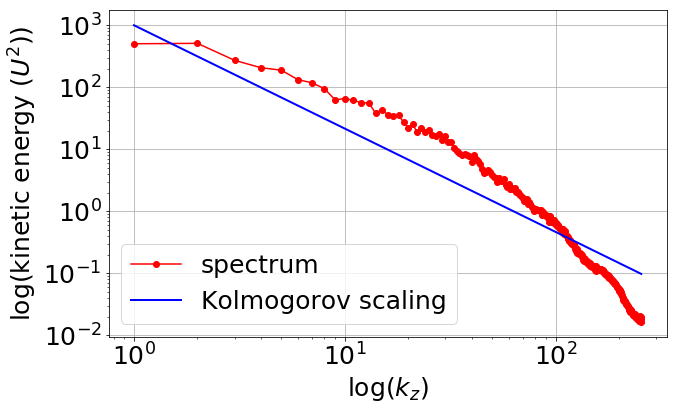

In [72]:
#fig = plt.figure(figsize = (4.8,3.6))
fig = plt.figure(figsize = (10,6))
#y_list = np.power(kth1,-5/3)                
ax = fig.add_subplot(111)
p = plt.plot(kz_512[1:],pz_array_512[1:], '-o',label = 'spectrum', color = 'red')
p2 = plt.plot(kz_512[1:], lawz_512[1:], label = 'Kolmogorov scaling', color = 'blue', linewidth = 2, linestyle = 'solid')
ax.grid()

plt.xlabel(r'log($k_z$)', fontsize = 25)
plt.ylabel('log(kinetic energy $(U^2)$)', fontsize = 25)
plt.yscale('log')
plt.xscale('log')
plt.legend()
#plt.title("QL kinetic energy spectrum over " + r'$k_z$' + ' turbulent state')
plt.savefig("/users/czhang54/scratch/ret120_analysis/ret120_power_vs_kz.png",bbox_inches="tight")
y_lim = ax.get_ylim()
x_lim = ax.get_xlim()
plt.show()
plt.close()

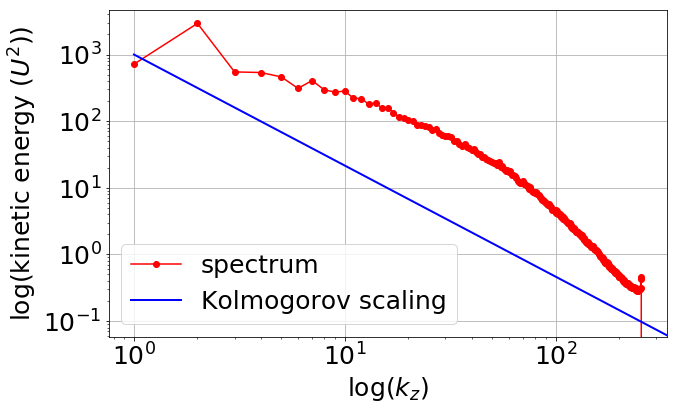

In [116]:
#fig = plt.figure(figsize = (4.8,3.6))
fig = plt.figure(figsize = (10,6))
#y_list = np.power(kth1,-5/3)                
ax = fig.add_subplot(111)
p = plt.plot(kz[1:],pz_array[1:], '-o',label = 'spectrum', color = 'red')
p2 = plt.plot(kz[1:], lawz[1:], label = 'Kolmogorov scaling', color = 'blue', linewidth = 2, linestyle = 'solid')
ax.grid()

plt.xlabel(r'log($k_z$)', fontsize = 25)
plt.ylabel('log(kinetic energy $(U^2)$)', fontsize = 25)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(y_lim)
plt.xlim(x_lim)
#plt.title("QL kinetic energy spectrum over " + r'$k_z$' + ' turbulent state')
plt.savefig("/users/czhang54/scratch/NL_analysis/ret65_nl_power_vs_kz_1024.png",bbox_inches="tight")
plt.show()
plt.close()